# Compondo com inteligência
Mateus Augusto Viotto - PC3008967

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, transform, util
import skimage

import tensorflow.compat.v1 as tf
import cv2
import itertools

from music21 import *

# Substitua o caminho abaixo pelo caminho real no seu sistema
environment.UserSettings()['musescoreDirectPNGPath'] = r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe'

#from google.colab.patches import cv2_imshow

## Altere para os diretórios correspondentes

In [2]:
diretorio_vocabulario = 'vocabulary_semantic.txt' #ALTERE PARA O DIRETÓRIO DO VOCABULARIO DISPONÍVEL EM https://github.com/OMR-Research/tf-end-to-end/blob/master/Data/vocabulary_semantic.txt
diretorio_modelo = 'model\semantic_model.meta' #ALTERE PARA O DIRETÓRIO DO MODELO DISPONÍVEL EM https://grfia.dlsi.ua.es/primus/models/PrIMuS/Semantic-Model.zip

# Carrega dados do arquivo 'clef.xlsx' para o DataFrame 'clef'
clef = pd.read_excel('clef.xlsx')

# Carrega dados do arquivo 'gracenote.xlsx' para o DataFrame 'gracenote'
gracenote = pd.read_excel('gracenote.xlsx')
gracenote['oitava'] = gracenote['oitava'].astype(str).str.replace('.0', '')

# Carrega dados do arquivo 'keySignature.xlsx' para o DataFrame 'keySignature'
keySignature = pd.read_excel('keySignature.xlsx')

# Carrega dados do arquivo 'notes.xlsx' para o DataFrame 'notes'
notes = pd.read_excel('notes.xlsx')
notes['oitava'] = notes['oitava'].astype(str).str.replace('.0', '')

# Carrega dados do arquivo 'options.xlsx' para o DataFrame 'options'
options = pd.read_excel('options.xlsx')

# Carrega dados do arquivo 'rest.xlsx' para o DataFrame 'rest'
rest = pd.read_excel('rest.xlsx')

# Carrega dados do arquivo 'timeSignature.xlsx' para o DataFrame 'timeSignature'
timeSignature = pd.read_excel('timeSignature.xlsx')

C:\Users\mateu\AppData\Local\Temp\ipykernel_5908\1204828071.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  gracenote['oitava'] = gracenote['oitava'].astype(str).str.replace('.0', '')
C:\Users\mateu\AppData\Local\Temp\ipykernel_5908\1204828071.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  notes['oitava'] = notes['oitava'].astype(str).str.replace('.0', '')


In [3]:
duracoes_musicais = {
    'double_whole': 4.0,
    'double_whole_fermata': 4.0,
    'double_whole.': 4.0,
    'double_whole._fermata': 4.0,
    'eighth': 0.5,
    'eighth_fermata': 0.5,
    'eighth.': 0.5,
    'eighth._fermata': 0.5,
    'eighth..': 0.5,
    'half': 2.0,
    'half_fermata': 2.0,
    'half.': 2.0,
    'half._fermata': 2.0,
    'half..': 2.0,
    'hundred_twenty_eighth': 0.0078125,
    'quadruple_whole': 16.0,
    'quadruple_whole_fermata': 16.0,
    'quadruple_whole.': 16.0,
    'quarter': 1.0,
    'quarter_fermata': 1.0,
    'quarter.': 1.0,
    'quarter._fermata': 1.0,
    'quarter..': 1.0,
    'quarter.._fermata': 1.0,
    'sixteenth': 0.25,
    'sixteenth_fermata': 0.25,
    'sixteenth.': 0.25,
    'sixteenth._fermata': 0.25,
    'sixteenth..': 0.25,
    'sixty_fourth': 0.03125,
    'sixty_fourth.': 0.03125,
    'thirty_second': 0.015625,
    'thirty_second.': 0.015625,
    'whole': 4.0,
    'whole_fermata': 4.0,
    'whole.': 4.0,
    'whole._fermata': 4.0,
}

assinaturas_clave = {
    'AbM': -4,   # Quatro bemóis: Bb, Eb, Ab, Db
    'AM': 0,     # Nenhuma alteração
    'BbM': -2,   # Dois bemóis: Bb, Eb
    'BM': 2,     # Dois sustenidos: F#, C#
    'C#M': 7,    # Sete sustenidos: F#, C#, G#, D#, A#, E#, B#
    'CM': 0,     # Nenhuma alteração
    'DbM': -5,   # Cinco bemóis: Bb, Eb, Ab, Db, Gb
    'DM': 2,     # Dois sustenidos: F#, C#
    'EbM': -3,   # Três bemóis: Bb, Eb, Ab
    'EM': 4,     # Quatro sustenidos: F#, C#, G#, D#
    'F#M': 6,    # Seis sustenidos: F#, C#, G#, D#, A#, E#
    'FM': 1,     # Um sustenido: F#
    'GbM': -6,   # Seis bemóis: Bb, Eb, Ab, Db, Gb, Cb
    'GM': 1      # Um sustenido: F#
}

## Funções ler e salvar

Salva a imagem em formato *jpg* no diretório atual.

In [4]:
def salvar_imagem(imagem, nome):
  io.imsave(nome+'.jpg', imagem)

Lê o vocabulário armazenado no arquito *txt* e armazena em um dicionário.

In [5]:
def ler_vocabulario(diretorio):
    # Abra o arquivo para leitura
    with open(diretorio, 'r') as arquivo:
      # Leia as linhas e armazene em uma lista
      linhas = arquivo.readlines()

    # Cada elemento da lista representa uma linha do arquivo

    dicionario = dict()
    i = 0
    for palavra in linhas:

        dicionario[i] = palavra.replace("\n", "")
        i += 1
    return dicionario


In [6]:
def mostrar_imagem(img):
    # Exiba a imagem usando matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')  # Desliga os eixos
        plt.show()

## Funções Pré-processamento

### Converte uma imagem colorida para escala de cinza.

In [7]:
def deixar_cinza(imagem):
    #print('Convertendo para escala de cinza. . .')
    return cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

### Binariza a imagem utilizando o método *threshold_sauvola*.

In [8]:
def binarizar(image):
    from skimage.filters import threshold_sauvola
    #print('Binarizando imagem. . .')
    # tamanho da janela de cálculo local do limiar
    window_size = 101

    # fator de sensibilidade
    k = 0.1

    # Calcule o limiar de Sauvola
    threshold = threshold_sauvola(image, window_size=window_size, k=k)

    # Aplique o limiar à imagem para binarizá-la
    binary_image = image > threshold

    return binary_image


### Plota um gráfico horizontal da projeção horizontal para visualização da linha de pauta.

In [9]:
def linhadepauta(projection_data):
    import matplotlib.pyplot as plt

    # Combina os arrays em um único array
    combined_data = [item for sublist in projection_data for item in sublist]

    # Define o intervalo de exibição no eixo X
    x_values = range(1, len(combined_data) + 1)  # De 1 a N

    # Define o passo para os rótulos do eixo X (exibe a cada 300 valores)
    x_ticks = list(range(1, len(combined_data) + 1, 50))  # Exibe a cada 300 valores

    # Cria um gráfico de barras horizontais
    plt.barh(x_values, combined_data, color='black')

    # Inverte o eixo Y para que os valores mais altos fiquem no topo
    plt.gca().invert_yaxis()

    # Configura os rótulos do eixo X
    plt.yticks(x_ticks, x_ticks)

    plt.show()

### Calcula a projeção horizontal.

In [10]:
def calcular_projecao(img_data, col_row=1):
    #print('Calculando projeção horizontal. . .')
    # Cria uma máscara onde os valores 0 na imagem original são mapeados para 1, e outros para 0
    mask = np.uint8(np.where(img_data == 0, 1, 0))

    # Calcula a projeção somando os valores na máscara ao longo de uma coluna (col_row=1) ou linha (col_row=0)
    # REDUCE_SUM realiza a soma
    # dtype=cv2.CV_32SC1 define o tipo de dados do resultado como 32 bits com sinal
    count = cv2.reduce(mask, col_row, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

    return count

### Rotaciona a imagem.

In [11]:
def girar_imagem(img_data, angle):

    # Rotacionar a imagem
    new_image = util.img_as_ubyte(transform.rotate(img_data, angle, mode='wrap'))

    return new_image

### Endireita a imagem, rotacionando-a caso esteja inclinada.

In [12]:
def alinhar_linhas(img_data):
    #print('Alinhando a imagem. . .')
    best_image = None  # Variável para armazenar a melhor imagem alinhada
    maximum = 0  # Variável para armazenar o valor máximo de projeção

    # Loop através de diferentes ângulos de rotação
    for i in range(-40, 40):
        angle = 0.25 * i  # Calcula o ângulo de rotação correspondente

        # Gira a imagem original pelo ângulo calculado
        new_image = girar_imagem(img_data, angle)

        # Binariza a nova imagem (converte para imagem binária)
        binary_image = binarizar(new_image)

        # Calcula a projeção horizontal da imagem binária
        horizontal_projection = calcular_projecao(binary_image)

        # Encontra o valor máximo na projeção horizontal
        max_projection = max(horizontal_projection)

        # Verifica se o valor máximo encontrado é maior que o máximo atual
        if max_projection > maximum:
            best_image = new_image  # Se for maior, atualiza a melhor imagem
            maximum = max_projection  # Atualiza o valor máximo

    return best_image  # Retorna a melhor imagem alinhada

In [13]:
def get_reference_lenghts(img_data):
    # Dicionários para armazenar o número de corridas de pixels pretos e brancos
    black_runs = {}
    white_runs = {}

    # Itera sobre todas as colunas da imagem
    for i in range(img_data.shape[1]):
        col = img_data[:, i]
        
        # Agrupa os valores consecutivos na coluna
        for k, g in itertools.groupby(col):
            length = len(list(g))
            
            # Atualiza os dicionários com base na cor do pixel
            if k == 0:
                black_runs[length] = black_runs.get(length, 0) + 1
            else:
                white_runs[length] = white_runs.get(length, 0) + 1

    # Determina a espessura da linha e o espaço entre linhas com base nas corridas
    line_thickness = max(black_runs, key=black_runs.get)
    staff_space = max(white_runs, key=white_runs.get)

    return line_thickness, staff_space

### Identificar pautas

In [14]:
def identificarpautas(img):
 
    
    print("Identificando as pautas. . .")
    image = img.copy()

    # Obtém as dimensões da imagem
    altura, largura = image.shape

    # Lista para armazenar as pautas identificadas
    pautas = []

    # Converte a imagem em escala de cinza
    #cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplica o detector de bordas Canny
    canny = cv2.Canny(img, 80, 200)

    # Detecta linhas na imagem usando a transformada de Hough
    linhas = cv2.HoughLinesP(canny, 1, np.pi / 180, 70, minLineLength=30, maxLineGap=5)

    # Desenha as linhas detectadas na imagem original
    for linha in linhas:
        x1, y1, x2, y2 = linha[0]
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 0), 10)
  
    # Converte a imagem novamente em escala de cinza
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplica um desfoque gaussiano
    blur = cv2.GaussianBlur(img, (7, 7), 0)

    # Aplica uma limiarização binária inversa
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Define um kernel para a operação de dilatação
    kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))

    # Realiza a dilatação para unir áreas próximas
    dilate = cv2.dilate(thresh, kernal, iterations=0)

    # Encontra os contornos na imagem dilatada
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
 
    # Itera sobre os contornos encontrados
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)

        # Verifica se o contorno representa uma pauta musical
        if h > 20 and w > largura // 2 and h < altura - 20:
            roi = image[y:y + h, x:x + w]
            pautas.append(roi)

    # Inverte a ordem das pautas para a exibição correta
    pautas.reverse()

    # Exibe cada pauta encontrada
    for p in pautas:
        print('\n')
        mostrar_imagem(p)
    return pautas

## Funções Identificar Símbolos

### Normaliza a imagem

In [15]:
def normalize(image):
    print('Normalizando a imagem. . .')
    return (255. - image)/255.

### Redimenciona a imagem

In [16]:
def resize(image, height):
    print('Redimencionando a imagem. . .')
    # Calcula a largura proporcional à altura fornecida
    width = int(float(height * image.shape[1]) / image.shape[0])

    # Redimensiona a imagem para a nova largura e altura
    sample_img = cv2.resize(image, (width, height))

    return sample_img

In [17]:
def sparse_tensor_to_strs(sparse_tensor):
    # Extrai os componentes do tensor esparsa
    indices = sparse_tensor[0][0]
    values = sparse_tensor[0][1]
    dense_shape = sparse_tensor[0][2]

    # Inicializa uma lista de listas para armazenar as strings
    strs = [[] for i in range(dense_shape[0])]

    # Inicializa uma lista temporária para armazenar cada string
    string = []
    ptr = 0
    b = 0

    # Itera sobre os índices para construir as strings
    for idx in range(len(indices)):
        # Verifica se mudou de linha
        if indices[idx][0] != b:
            strs[b] = string
            string = []
            b = indices[idx][0]

        # Adiciona o valor atual à string temporária
        string.append(values[ptr])

        ptr = ptr + 1

    # Armazena a última string na linha final
    strs[b] = string

    return strs


### Identifica os símbolos

In [18]:
def identificar_simbolos(imagem, vocabulario, diretorio):
    print('Identificando os símbolos')
    # Desabilita a execução ansiosa
    tf.compat.v1.disable_eager_execution()
    # Cria um novo grafo padrão do TensorFlow
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    # Cria um objeto Saver para importar o modelo
    saver = tf.train.import_meta_graph(diretorio)

    # Restaura os parâmetros do modelo a partir do arquivo
    saver.restore(sess, diretorio[:-5])  # Remove a extensão ".meta" do diretório
    graph = tf.get_default_graph()
    
    # Obter tensores necessários do grafo
    input = graph.get_tensor_by_name("model_input:0")  # Dados de entrada
    seq_len = graph.get_tensor_by_name("seq_lengths:0")  # Comprimento da sequência
    rnn_keep_prob = graph.get_tensor_by_name("keep_prob:0")  # Probabilidade de manter unidades
    height_tensor = graph.get_tensor_by_name("input_height:0")  # Altura da entrada
    width_reduction_tensor = graph.get_tensor_by_name("width_reduction:0")  # Redução de largura
    logits = tf.get_collection("logits")[0]  # Saídas da rede neural (normalmente, saídas da camada softmax)

    # Obter constantes do modelo
    WIDTH_REDUCTION, HEIGHT = sess.run([width_reduction_tensor, height_tensor])

    decoded, _ = tf.nn.ctc_greedy_decoder(logits, seq_len)  # Decodificação CTC

    # Pré-processamento da imagem de entrada
    image = imagem
    image = resize(image, HEIGHT)  # Redimensiona a imagem
    image = normalize(image)  # Normaliza a imagem
    image = np.asarray(image).reshape(1, image.shape[0], image.shape[1], 1)  # Formata a imagem para o modelo

    seq_lengths = [image.shape[2] / WIDTH_REDUCTION]  # Comprimento da sequência

    # Executa a rede neural com a imagem de entrada
    prediction = sess.run(decoded, feed_dict={
        input: image,
        seq_len: seq_lengths,
        rnn_keep_prob: 1.0,
    })

    # Converte a saída da decodificação em texto usando o vocabulário
    str_predictions = sparse_tensor_to_strs(prediction)

    # Retorna a lista de símbolos reconhecidos
    return [vocabulario[w] for w in str_predictions[0]]

## Funções Correção

### Pré-correção

In [19]:
def precorrecao(pauta, primeira):
    pauta_corrigida = []
    print('Pré-corrigindo os resultados. . .\n')

    #Verifica se tem uma clave no começo da pauta
    if 'clef' not in pauta[0]:
        pauta.insert(0, 'clef-G2')

    #Verifica se tem um tempo no começo da pauta
    if 'timeSignature' not in pauta[1] and 'timeSignature' not in pauta[2] and primeira == True:
        if 'keySignature' in pauta[1]:
            pauta.insert(2, 'timeSignature-3/4')
        else:
            pauta.insert(1, 'timeSignature-3/4')

    #Verifica se existem dois barline's seguidos
    i = 0
    while i < len(pauta) - 1:
        if pauta[i] == 'barline' and pauta[i + 1] == 'barline':
            # Se dois itens 'barline' consecutivos forem encontrados, remova um deles
            pauta.pop(i + 1)
        else:
            i += 1

    #Separa os compassos
    compassos = []
    compasso_atual = []

    for item in pauta:
        compasso_atual.append(item)
        if item == 'barline':
            compassos.append(compasso_atual)
            compasso_atual = []

    if compasso_atual:
        compassos.append(compasso_atual)

    #Verifica cada compasso
    for comp in compassos:
        # Encontra o índice da primeira ocorrência de uma palavra contendo "clef"
        index_to_keep = -1

        for i, item in enumerate(comp):
            if 'clef' in item:
                index_to_keep = i
                break

        # Remove todas as outras ocorrências de palavras contendo "clef"
        comp = [item for i, item in enumerate(comp) if i == index_to_keep or 'clef' not in item]


        # Encontra o índice da primeira ocorrência de uma palavra contendo "timeSignature"
        index_to_keep = -1

        for i, item in enumerate(comp):
            if 'timeSignature' in item:
                index_to_keep = i
                break

        # Remove todas as outras ocorrências de palavras contendo "timeSignature"
        comp = [item for i, item in enumerate(comp) if i == index_to_keep or 'timeSignature' not in item]

        # Encontra o índice da primeira ocorrência de uma palavra contendo "keySignature"
        index_to_keep = -1

        for i, item in enumerate(comp):
            if 'keySignature' in item:
                index_to_keep = i
                break

        # Remove todas as outras ocorrências de palavras contendo "keySignature"
        comp = [item for i, item in enumerate(comp) if i == index_to_keep or 'keySignature' not in item]

        for c in comp:
            pauta_corrigida.append(c)

    return pauta_corrigida

### Correção do usuário

In [20]:
def correcaoUsuario(pauta,img):
    print('Iniciando a correção do usuário. . .\n')
    
    while True:
        mostrar_imagem(img)
        print('\n',pauta)
        
        # Pergunta ao usuário se a classificação está correta
        resposta = int(input('\nA classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)'))

        if resposta == 1:
            return pauta

        elif resposta == 2:
            i = 1
            print('\nQual a posição do elemento que deseja alterar?')

            # Mostra os elementos da pauta e solicita a posição do elemento a ser alterado
            for elem in pauta:
                print('\n'+str(i) + '-' + elem, end='  ')
                i = i + 1
            posicao = int(input())

            # Pergunta ao usuário qual tipo de alteração deseja realizar
            alteracao = int(input('\nQual alteração deseja realizar? (1- Adicionar | 2- Editar | 3- Deletar)'))

            # Executa a ação correspondente com base na escolha do usuário
            if alteracao == 1:
                pauta = adicionar(pauta, posicao - 1)
            elif alteracao == 2:
                pauta = editar(pauta, posicao - 1)
            elif alteracao == 3:
                pauta = deletar(pauta, posicao - 1)
            else:
                # Mensagem de erro se a opção escolhida não for válida
                print('\nUtilize 1 para Adicionar, 2 para Editar ou 3 para Deletar.')
                correcaoUsuario(pauta)
        elif resposta == 3:
            return ''
        else:
            # Mensagem de erro se a opção escolhida não for válida
            print('\nUtilize 1 para Sim ou 2 para Não.')


### Deletar

In [21]:
def deletar(pauta, posicao):
    del pauta[posicao] #Deleta o elemento da pauta
    return pauta

### Adicionar

In [22]:
def adicionar(pauta, posicao):
    # Solicita a posição de adição do novo elemento
    pos = int(input('\nOnde deseja adicionar o novo elemento? 1- A frente | 2- Atrás'))
    if pos == 1:
        posicao = posicao + 1
    elif pos == 2: 
        posicao = posicao - 1

    # Solicita o tipo de elemento a ser adicionado
    print('\nQual elemento deseja adicionar? Utilize o número referente ao elemento.')
    display(options)
    elemento = int(input())

    if elemento == 0:
        # Substitui o elemento atual por uma nova nota musical
        nota = notes['nota'].dropna()
        oitava = notes['oitava'].dropna()
        oitava = oitava[:6]
        ritmo = notes['ritmo'].dropna()

        print('\nQual nota deseja adicionar? Utilize o número referente a nota.')
        display(nota)
        pos_nota = int(input())

        print('\nQual a oitava da nota? Utilize o número referente a oitava.')
        display(oitava)
        pos_oitava = int(input())

        print('\nQual o ritmo da nota? Utilize o número referente ao ritmo.')
        display(ritmo)
        pos_ritmo = int(input())

        novo_elemento = 'note-' + nota.iloc[pos_nota] + str(oitava.iloc[pos_oitava]) + '_' + ritmo.iloc[pos_ritmo]

    elif elemento == 1:
        # Substitui o elemento atual por um novo descanso
        print('\nQual rest deseja adicionar? Utilize o número referente a rest.')
        display(rest)
        elem = int(input())
        novo_elemento = 'rest-' + rest.iloc[elem]['rest']
    
    elif elemento == 2:
        print('\nQual timeSignature deseja adicionar? Utilize o número referente ao timeSignature.')
        display(timeSignature)
        elem = int(input())
        novo_elemento = 'timeSignature-' + timeSignature.iloc[elem]['timeSignature']
    
    elif elemento == 3:
        print('\nQual clef deseja adicionar? Utilize o número referente a clef.')
        display(clef)
        elem = int(input())
        novo_elemento = 'clef-' + clef.iloc[elem]['clef']
    
    elif elemento == 4:
        novo_elemento = 'tie'
    
    elif elemento == 5:
        novo_elemento = 'barline'

    elif elemento == 6:
        # Substitui o elemento atual por uma nova nota musical
        nota = gracenote['nota'].dropna()
        oitava = gracenote['oitava'].dropna()
        oitava = oitava[:6]
        ritmo = gracenote['ritmo'].dropna()

        print('\nQual gracenote deseja adicionar? Utilize o número referente a gracenote.')
        display(nota)
        pos_nota = int(input())

        print('\nQual a oitava da gracenote? Utilize o número referente a oitava.')
        display(oitava)
        pos_oitava = int(input())

        print('\nQual o ritmo da gracenote? Utilize o número referente ao ritmo.')
        display(ritmo)
        pos_ritmo = int(input())

        novo_elemento = 'gracenote-' + gracenote.iloc[pos_nota] + str(oitava.iloc[pos_oitava]) + '_' + ritmo.iloc[pos_ritmo]

    elif elemento == 7:
        # Substitui o elemento atual por uma nova keySignature
        print('\nQual keySignature deseja adicionar? Utilize o número referente a keySignature.')
        display(keySignature)
        elem = int(input())
        novo_elemento = 'keySignature-' + keySignature.iloc[elem]['keySignature']


    pauta.insert(posicao, novo_elemento)
    return pauta


### Editar

In [23]:
def editar(pauta, posicao):
    # Solicita o tipo de elemento a ser usado para a substituição
    print('\nQual elemento deseja substituir o ' + pauta[posicao] + '? Utilize o número referente ao elemento.')
    display(options)
    elemento = int(input())

    if elemento == 0:
        # Substitui o elemento atual por uma nova nota musical
        nota = notes['nota'].dropna()
        oitava = notes['oitava'].dropna()
        oitava = oitava[:6]
        ritmo = notes['ritmo'].dropna()

        print('\nQual nota deseja adicionar? Utilize o número referente a nota.')
        display(nota)
        pos_nota = int(input())

        print('\nQual a oitava da nota? Utilize o número referente a oitava.')
        display(oitava)
        pos_oitava = int(input())

        print('\nQual o ritmo da nota? Utilize o número referente ao ritmo.')
        display(ritmo)
        pos_ritmo = int(input())

        novo_elemento = 'note-' + nota.iloc[pos_nota] + str(oitava.iloc[pos_oitava]) + '_' + ritmo.iloc[pos_ritmo]

    elif elemento == 1:
        # Substitui o elemento atual por um novo descanso
        print('\nQual rest deseja adicionar? Utilize o número referente a rest.')
        display(rest)
        elem = int(input())
        novo_elemento = 'rest-' + rest.iloc[elem]['rest']
    
    elif elemento == 2:
        print('\nQual timeSignature deseja adicionar? Utilize o número referente ao timeSignature.')
        display(timeSignature)
        elem = int(input())
        novo_elemento = 'timeSignature-' + timeSignature.iloc[elem]['timeSignature']
    
    elif elemento == 3:
        print('\nQual clef deseja adicionar? Utilize o número referente a clef.')
        display(clef)
        elem = int(input())
        novo_elemento = 'clef-' + clef.iloc[elem]['clef']
    
    elif elemento == 4:
        novo_elemento = 'tie'
    
    elif elemento == 5:
        novo_elemento = 'barline'

    elif elemento == 6:
        # Substitui o elemento atual por uma nova nota musical
        nota = gracenote['nota'].dropna()
        oitava = gracenote['oitava'].dropna()
        oitava = oitava[:6]
        ritmo = gracenote['ritmo'].dropna()

        print('\nQual gracenote deseja adicionar? Utilize o número referente a gracenote.')
        display(nota)
        pos_nota = int(input())

        print('\nQual a oitava da gracenote? Utilize o número referente a oitava.')
        display(oitava)
        pos_oitava = int(input())

        print('\nQual o ritmo da gracenote? Utilize o número referente ao ritmo.')
        display(ritmo)
        pos_ritmo = int(input())

        novo_elemento = 'gracenote-' + gracenote.iloc[pos_nota] + str(oitava.iloc[pos_oitava]) + '_' + ritmo.iloc[pos_ritmo]

    elif elemento == 7:
        # Substitui o elemento atual por uma nova keySignature
        print('\nQual keySignature deseja adicionar? Utilize o número referente a keySignature.')
        display(keySignature)
        elem = int(input())
        novo_elemento = 'keySignature-' + keySignature.iloc[elem]['keySignature']

    # Atualiza a pauta na posição especificada
    pauta[posicao] = novo_elemento
        
    return pauta


## Funções gerar partitura e MIDI

In [24]:
from music21 import stream, key, meter, note

def criar_partitura(elements, assinaturas_clave, duracoes_musicais, titulo='Minha Partitura'):
    score = stream.Score()
    partitura = stream.Part()
    #alto = clef.AltoClef()
    #partitura = stream.Measure([alto])
    current_key = None  # Manter o controle da tonalidade atual
    # Adicionar metadados à partitura (incluindo o título)
    metadados = metadata.Metadata()
    metadados.title = titulo
    score.metadata = metadados
    
    for element in elements:
    
        if element.startswith('keySignature'):
            key_signature = element.split('-')[1]
            # Adicione uma assinatura de clave com base no dicionário de assinaturas_clave
            assinatura_clave = assinaturas_clave.get(key_signature, None)
            if assinatura_clave is not None:
                # Converta a assinatura de clave para alterações antes de criar o objeto Key
                current_key = key.KeySignature(assinatura_clave)
                partitura.append(current_key)

        elif element.startswith('timeSignature'):
            time_signature = element.split('-')[1]
            if time_signature != 'C/':
                partitura.append(meter.TimeSignature(time_signature))

        elif element.startswith('rest'):
            _,duration = element.split('-')
            valor_quarterLength = duracoes_musicais.get(duration, None)
            if valor_quarterLength is not None:
                n = note.Rest(quarterLength=valor_quarterLength)
                partitura.append(n)
            
        elif element.startswith('note'):
            _, pitch_duration = element.split('-')
            separacao = pitch_duration.split('_')
            pitch = separacao[0]
            duration = separacao[1]
            # Usa a tonalidade atual para criar a nota
            valor_quarterLength = duracoes_musicais.get(duration, None)
            if valor_quarterLength is not None:
                n = note.Note(pitch, quarterLength=valor_quarterLength)
                partitura.append(n)

    # Adiciona a parte à partitura
    score.append(partitura)

    return score


## Reconhecimento dos símbolos e geração do MIDI

Identificando as pautas. . .




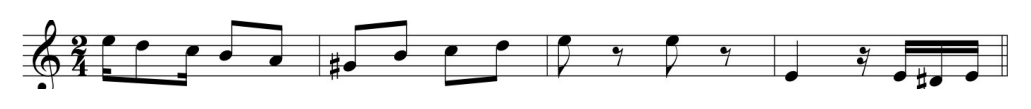

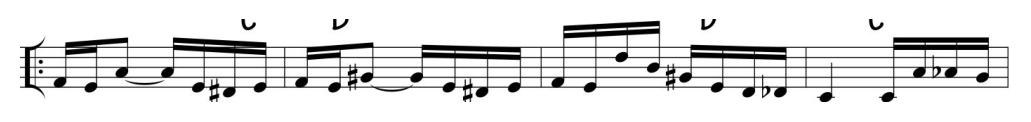

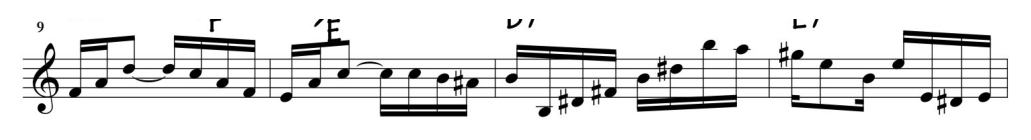

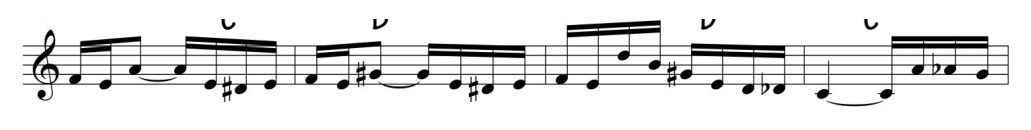

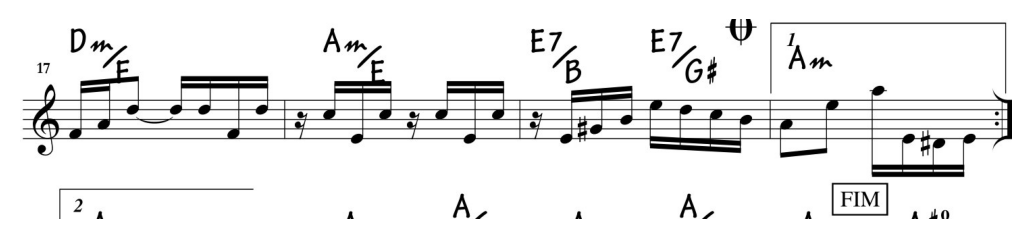

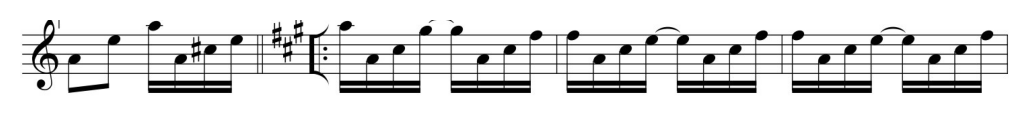

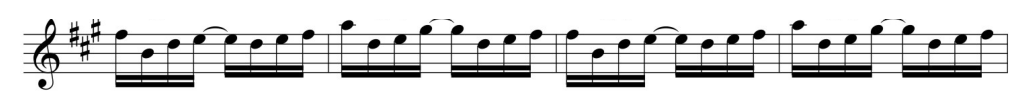

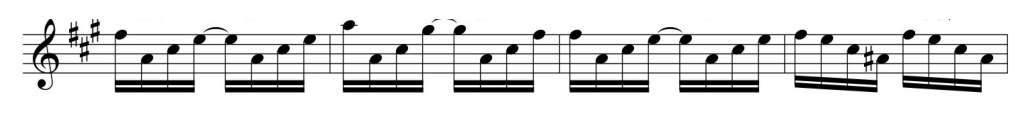


=================== Analisando pauta 1 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimencionando a imagem. . .
Normalizando a imagem. . .
['note-E5_sixteenth', 'note-D5_eighth.', 'tie', 'note-C4_sixteenth', 'note-B4_quarter_fermata', 'note-A4_eighth', 'barline', 'note-G#4_quarter', 'note-B4_quarter', 'note-C5_eighth', 'note-D5_eighth', 'barline', 'note-E5_eighth', 'rest-eighth', 'note-E5_eighth', 'rest-eighth', 'barline', 'note-E4_quarter', 'rest-sixteenth', 'note-E4_sixteenth', 'note-C4_sixteenth', 'note-B3_sixteenth', 'barline']
Pré-corrigindo os resultados. . .

Iniciando a correção do usuário. . .



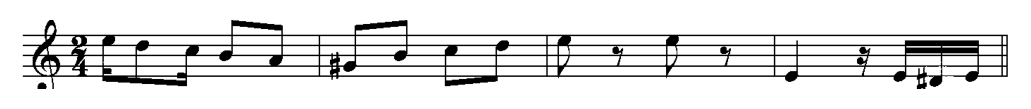


 ['clef-G2', 'timeSignature-3/4', 'note-E5_sixteenth', 'note-D5_eighth.', 'tie', 'note-C4_sixteenth', 'note-B4_quarter_fermata', 'note-A4_eighth', 'barline', 'note-G#4_quarter', 'note-B4_quarter', 'note-C5_eighth', 'note-D5_eighth', 'barline', 'note-E5_eighth', 'rest-eighth', 'note-E5_eighth', 'rest-eighth', 'barline', 'note-E4_quarter', 'rest-sixteenth', 'note-E4_sixteenth', 'note-C4_sixteenth', 'note-B3_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 2 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimencionando a imagem. . .
Normalizando a imagem. . .
['clef-C3', 'timeSignature-C', 'note-D3_eighth', 'note-B3_quarter', 'tie', 'note-B3_eighth', 'note-C4_sixteenth', 'note-D3_sixteenth', 'barline', 'note-G3_sixteenth', 

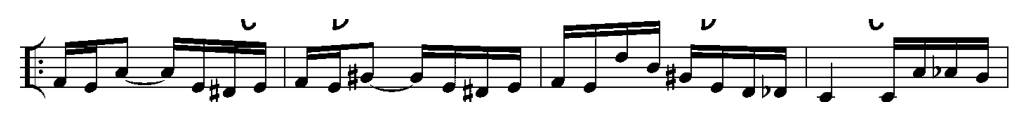


 ['clef-C3', 'timeSignature-C', 'note-D3_eighth', 'note-B3_quarter', 'tie', 'note-B3_eighth', 'note-C4_sixteenth', 'note-D3_sixteenth', 'barline', 'note-G3_sixteenth', 'note-D3_sixteenth', 'note-F#3_quarter', 'tie', 'note-A3_sixteenth', 'note-D3_sixteenth', 'note-D3_sixteenth', 'barline', 'note-G3_eighth', 'note-G2_sixteenth', 'note-E4_sixteenth', 'note-C4_sixteenth', 'note-A3_sixteenth', 'note-A2_sixteenth', 'note-D4_sixteenth', 'barline', 'note-D3_half', 'note-F3_eighth', 'note-B3_sixteenth', 'note-B3_sixteenth', 'note-A3_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 3 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimencionando a imagem. . .
Normalizando a imagem. . .
['clef-G2', 'note-F4_sixteenth', 'note-A4_sixt

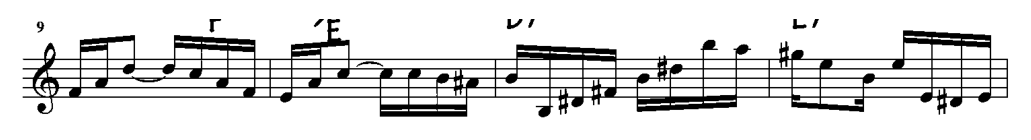


 ['clef-G2', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-D5_quarter', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'note-F4_sixteenth', 'barline', 'note-E4_sixteenth', 'note-A4_sixteenth', 'note-C5_quarter', 'note-C5_sixteenth', 'note-B4_sixteenth', 'note-A#4_eighth', 'barline', 'note-B4_sixteenth', 'note-B3_sixteenth', 'note-D#4_sixteenth', 'note-F#4_eighth', 'note-B4_sixteenth', 'note-D#5_sixteenth', 'note-B5_sixteenth', 'note-A5_sixteenth', 'barline', 'note-G#5_eighth', 'note-E5_eighth.', 'note-B4_sixteenth', 'note-E5_eighth', 'note-E4_sixteenth', 'note-D4_sixteenth.', 'note-E4_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 4 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimencionando a image

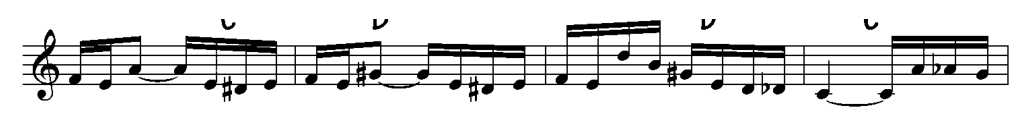


 ['clef-G2', 'note-F4_sixteenth', 'note-E4_sixteenth', 'note-A4_quarter', 'note-A4_sixteenth', 'note-E4_sixteenth', 'note-D#4_sixteenth', 'note-E4_sixteenth', 'barline', 'note-F4_sixteenth', 'note-E4_sixteenth', 'note-G#4_eighth', 'note-G#4_quarter', 'note-G4_sixteenth', 'note-E4_sixteenth', 'note-D#4_sixteenth', 'note-E4_sixteenth', 'barline', 'note-F4_eighth', 'note-E4_sixteenth', 'note-D5_sixteenth', 'note-B4_sixteenth', 'note-G#4_sixteenth', 'note-E4_sixteenth', 'note-D4_sixteenth', 'note-D#4_sixteenth', 'barline', 'note-C4_half', 'tie', 'note-C4_sixteenth', 'note-A4_sixteenth', 'note-Ab4_sixteenth', 'note-G4_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 5 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimenciona

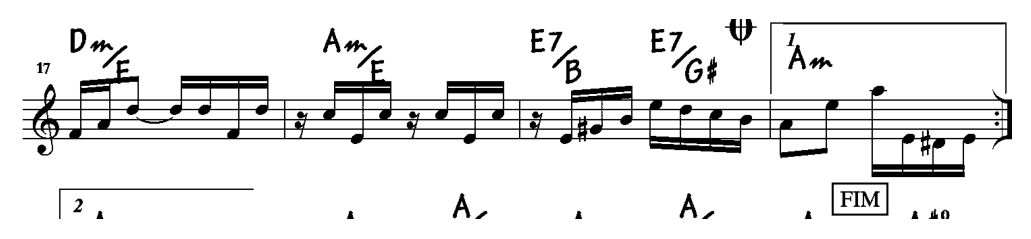


 ['clef-G2', 'keySignature-DM', 'timeSignature-C/', 'gracenote-F4_thirty_second', 'note-E4_sixteenth', 'gracenote-A4_sixteenth', 'rest-sixteenth', 'multirest-4', 'note-Eb4_eighth', 'note-F4_sixteenth', 'rest-sixteenth', 'note-G4_eighth', 'multirest-7', 'multirest-3', 'note-G4_eighth.', 'note-G4_eighth', 'note-G4_eighth', 'note-Bb4_eighth']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 6 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model
Redimencionando a imagem. . .
Normalizando a imagem. . .
['note-E5_quarter', 'note-A5_sixteenth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-E5_sixteenth', 'barline', 'clef-C4', 'note-E5_eighth', 'note-A5_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-G5_sixteenth', 'note-G5_eighth', 'note-A4_s

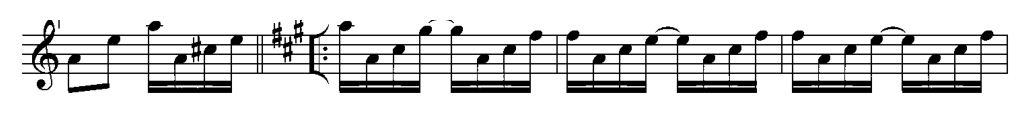


 ['clef-G2', 'note-E5_quarter', 'note-A5_sixteenth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-E5_sixteenth', 'barline', 'clef-C4', 'note-E5_eighth', 'note-A5_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-G5_sixteenth', 'note-G5_eighth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-F5_eighth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-E5_sixteenth', 'tie', 'note-E5_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-F5_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-E5_eighth', 'tie', 'note-E5_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F5_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 7 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Rest

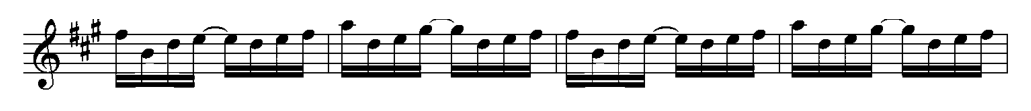


 ['clef-G2', 'keySignature-GM', 'timeSignature-C/', 'note-F#5_sixteenth', 'note-B4_sixteenth', 'note-D5_sixteenth', 'note-E5_eighth', 'tie', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-F#5_sixteenth', 'barline', 'note-A5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-G5_eighth', 'note-G#5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-F#5_sixteenth', 'barline', 'note-F#5_eighth', 'note-B4_sixteenth', 'note-D5_sixteenth', 'note-E5_eighth', 'tie', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-F#5_sixteenth', 'barline', 'note-A5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-G#5_sixteenth', 'note-G#5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-F#5_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1

=================== Analisando pauta 8 ===================

Alinhando a imagem. . .
Identificando os símbolos
'model_variables' collection should 

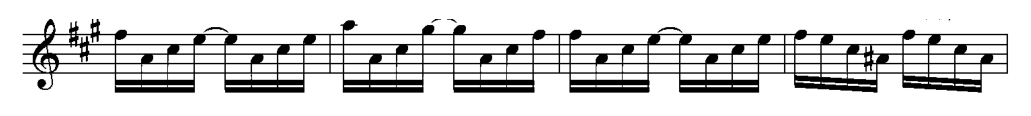


 ['clef-G2', 'timeSignature-C/', 'note-F#5_sixteenth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-E5_eighth', 'tie', 'note-E5_sixteenth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-E5_sixteenth', 'barline', 'note-A5_eighth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-G5_eighth', 'note-G5_eighth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-F#5_sixteenth', 'barline', 'note-F#5_sixteenth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-E5_eighth', 'tie', 'note-E5_sixteenth', 'note-A4_sixteenth', 'note-C#5_sixteenth', 'note-E5_sixteenth', 'barline', 'note-F#5_sixteenth', 'note-E5_sixteenth', 'note-C#5_sixteenth', 'note-A#4_eighth', 'note-F#5_sixteenth', 'note-E5_sixteenth', 'note-C#5_sixteenth', 'note-A4_sixteenth', 'barline']

A classificação está correta? (1- Sim | 2- Não  | 3- Pauta não existe)1
Qual o nome da partitura? Tico tico


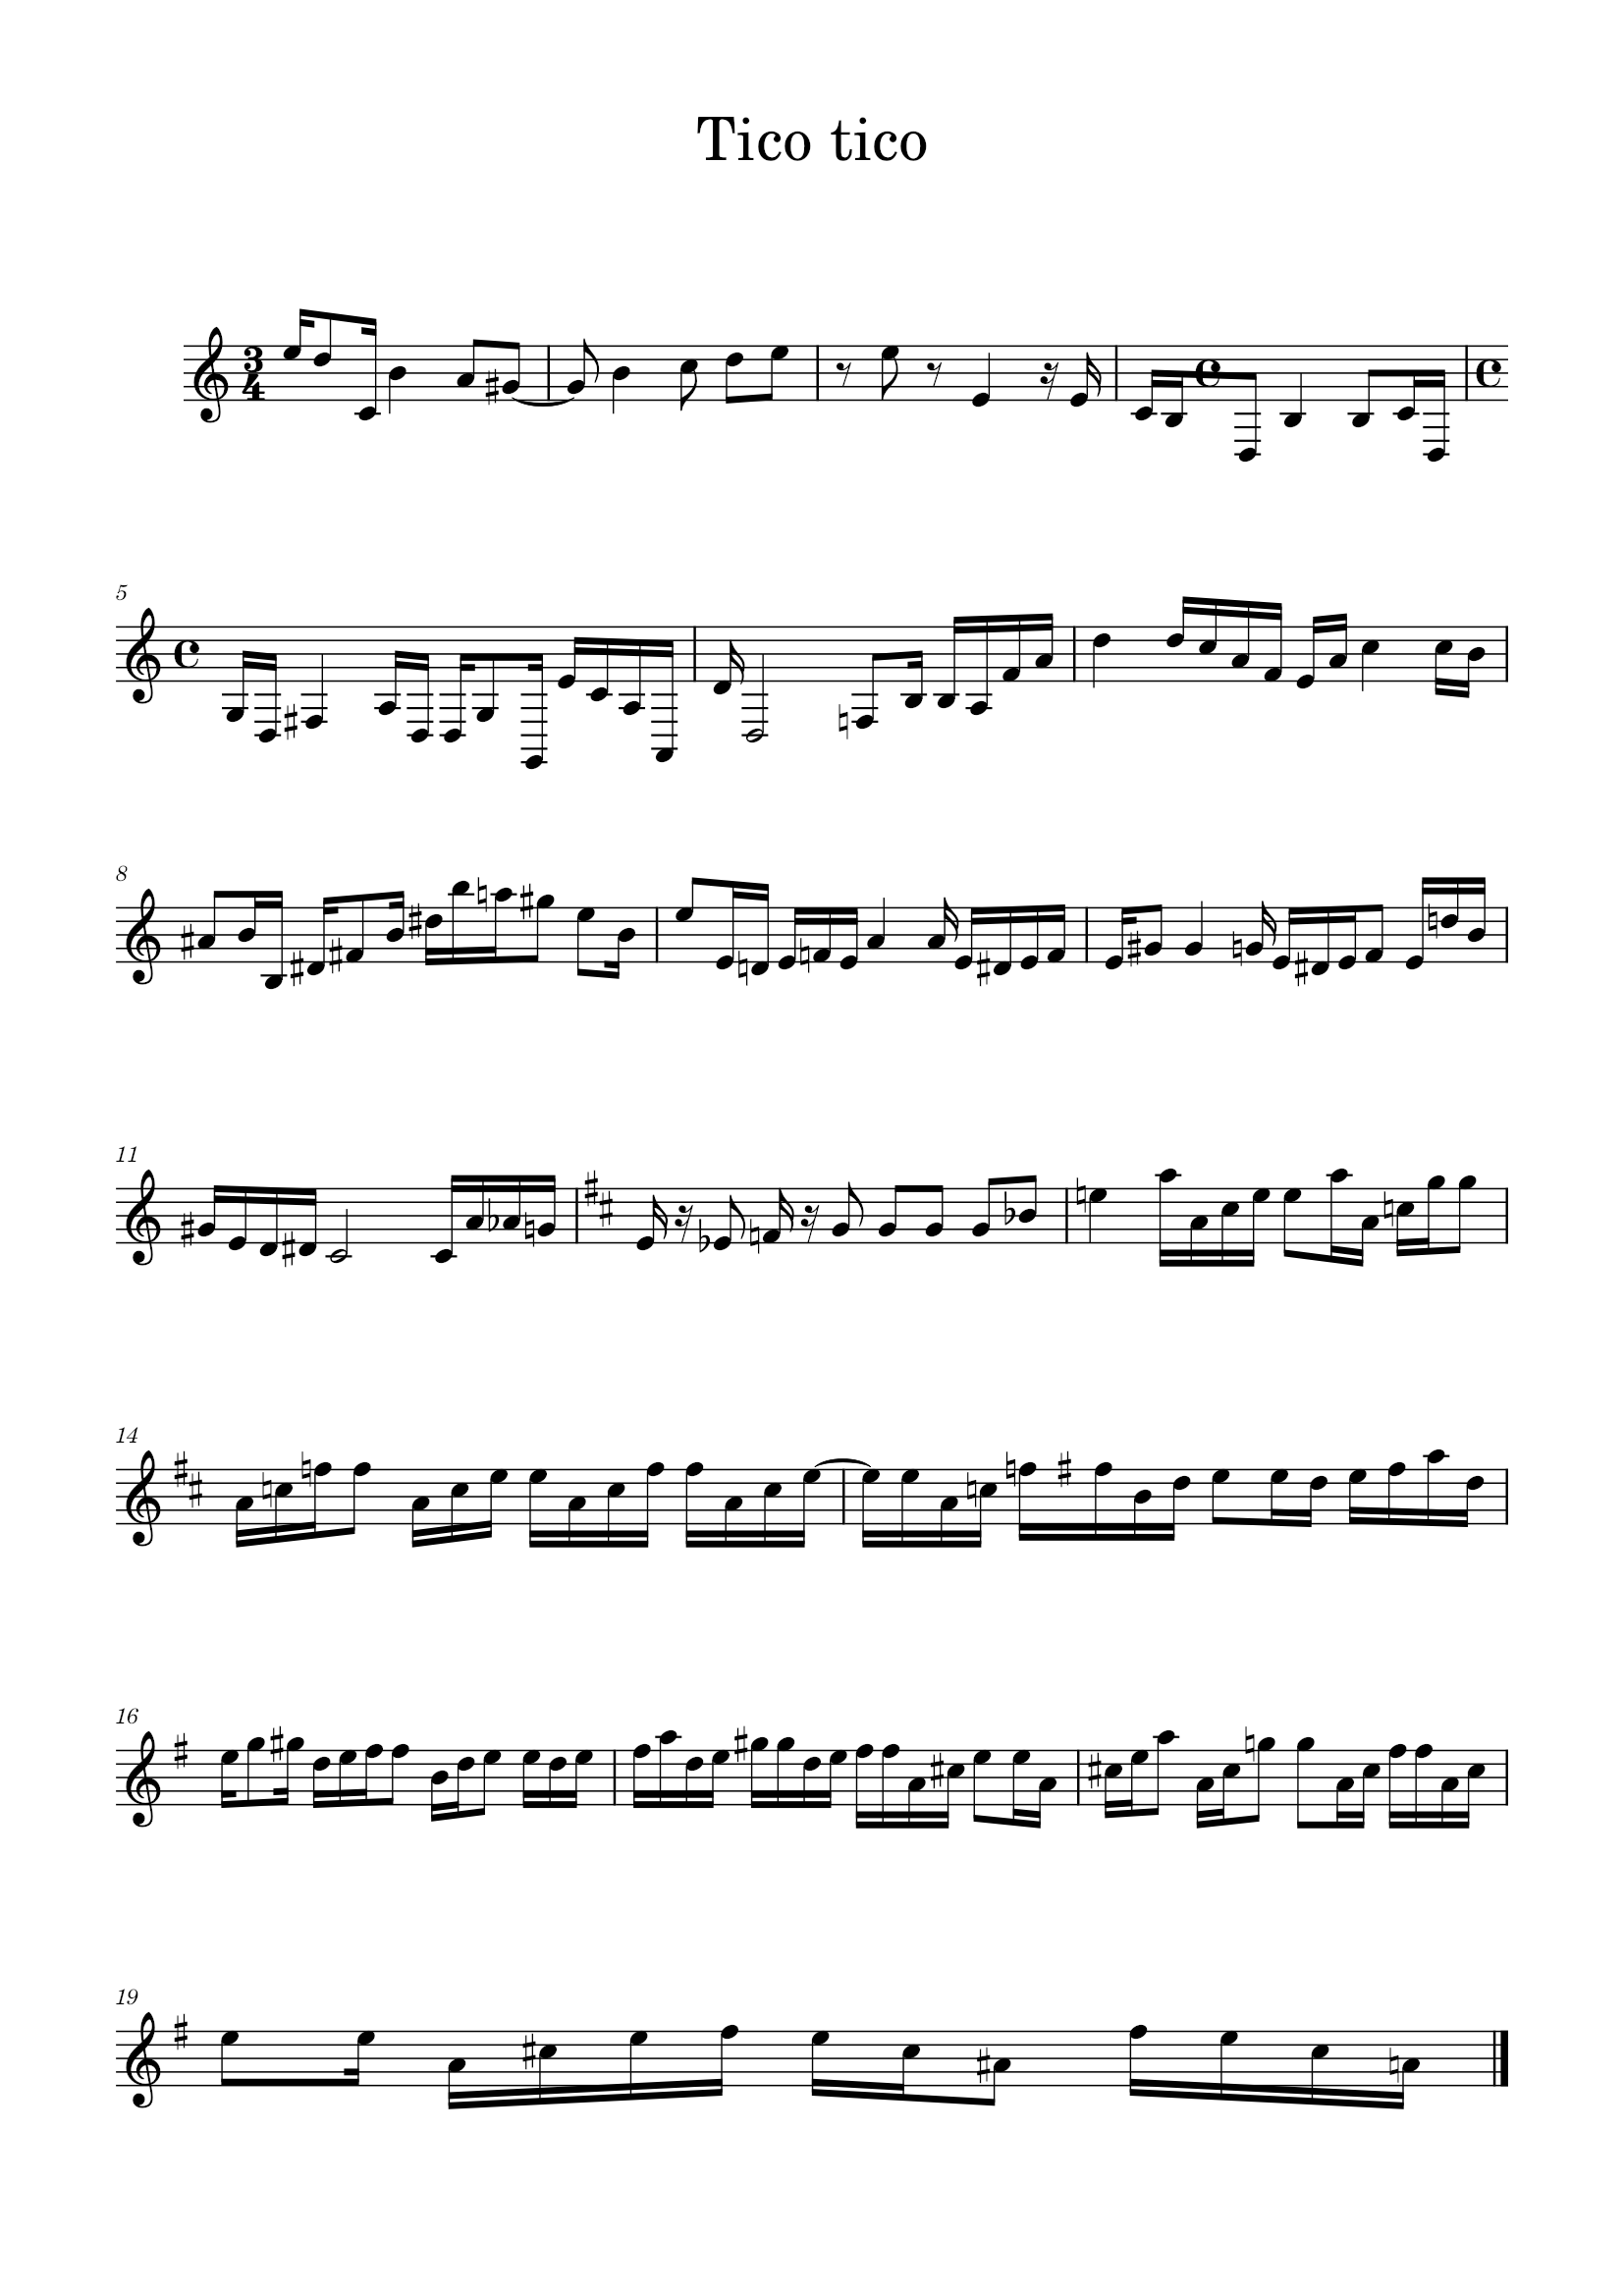

'Tico tico.mid'

In [32]:
diretorio_imagem = 'tico tico.jpg'

imagem = cv2.imread(diretorio_imagem)
imagem_cinza = deixar_cinza(imagem)
pautas = identificarpautas(imagem_cinza)
vocabulario = ler_vocabulario(diretorio_vocabulario)
pautafinal = []
i = 1
primeira = True

for pauta in pautas:
    print('\n=================== Analisando pauta '+str(i) +' ===================')
    i = i + 1
    imagem_binarizada = binarizar(pauta)
    
    #salvar_imagem(imagem_binarizada, 'images\\binarized\\'+diretorio_imagem[:-4]+'-binarizada')
    print('\nAlinhando a imagem. . .')
    imagem_alinhada = alinhar_linhas(imagem_binarizada)
    #salvar_imagem(imagem_alinhada, 'images\\aligned\\'+diretorio_imagem[:-4]+'-alinhada')

    #projecao = calcular_projecao(imagem_alinhada)
    #linhadepauta(projecao)
    
    # Use a função 'img_as_ubyte' para converter a imagem para ubytes
    img_data = skimage.img_as_ubyte(imagem_alinhada)
    
    line_thickness, staff_space = get_reference_lenghts(img_data)
    symbols = identificar_simbolos(img_data, vocabulario, diretorio_modelo)
    #print('\n', symbols)
    
    print(symbols)
    pautaprecorrigida = precorrecao(symbols, primeira)
    primeira = False
    pautacorrigida = correcaoUsuario(pautaprecorrigida, imagem_alinhada)
    
    for pau in pautacorrigida:
        pautafinal.append(pau)
    
#print('\nGerando classificação final. . .\n\n'+pautafinal)
titulo = input('Qual o nome da partitura? ')

# Cria a partitura
score = criar_partitura(pautafinal, assinaturas_clave, duracoes_musicais, titulo)

# Mostra a partitura
score.show()

score.write('midi', fp= titulo+'.mid')
